<a href="https://colab.research.google.com/github/JulianaHerreraM/hello-word/blob/master/Ciclo2Practica09_1093230672.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oscilaciones de una cuerda tensa

## **1. Objetivos**



*   Determinar los modos normales de vibración de una cuerda fija en ambos
extremos.
*   Verificar experimentalmente la relación de la frecuencias en estado de resonancia de las cuerdas con respecto a los parámetros: tensión, longitud y
densidad.
*   Encontrar la densidad de la cuerda utilizada.

Para realizar esta práctica se va a simular el siguiente experimento:

[Laboratorio virtual de ondas estacionarias](http://server.ce.tuiasi.ro/~radinschi/simulation/sim2/index.html)

En esta práctica se desea observar el compartamiento de oscilación de una cuerda tensa, de acuerdo a la magnitud de la tensión de la cuerda, así como a su longitud. Para el montaje que se va a simular en esta experiencia se tiene en cuenta que los elementos que permitirán varias la tensión y la longitud son: $9$ masas de $24~g$ cada una junto con un soporte de $49.8~g$, una cuerda de $1~m$ de extensión con una masa a considerar de $9.8726~g$.

## **2. Simulación**

### **2.1 Descripción del fenómeno**

La simulación de este escenario requiere la solución de la ecuación de onda:

$$\frac{\partial^{2}u}{\partial t^{2}} = v^{2} \frac{\partial^{2}u}{\partial x^{2}}$$

donde $x \in \{0,L\}$ y $t\in \{0,T\}$. Las condiciones de frontera son las siguientes:

*   $u(x,0) = I(x)$ es el estímulo externo en el primer instante de tiempo, o la forma de la onda en el primer instante de tiempo.

*   $\frac{\partial }{\partial t}u(x,0) = 0$ esto indica que no van a haber cambios de primer orden.

*   $u(0,t) = 0$ significa que el primer extremo de la cuerda está fijo

*   $u(L,t) = 0$ el segundo extremo de la cuerda también está fijo.

Por otra parte, se considera que $v$ es la velocidad de propagación de la onda, que para este caso corresponde a:

$$v = \sqrt{\frac{T}{\mu}}$$

donde $T$ es la tensión que sufre la cuerda (para eso son las masas mencionadas en la primera parte) y $\mu$ es la densidad lineal de la cuerda.


### **2.2 Simulación del fenómeno**

In [0]:
# Se importan las librerías requeridas para 
import moviepy.editor as mpy                            # Libreria para generar videos
import matplotlib.pyplot as plt                         # Libreria para graficar
import numpy as np
from numpy import linspace, zeros                       # Libreria para manipular matrices y vectores
from moviepy.video.io.bindings import mplfig_to_npimage # Libreria para convertir un set de imagenes en un vídeo
from ipywidgets import interact                         # Libreria para agregar botones interactivos

In [0]:
# Funcion que resuelve la ecuacion de onda

def solver(I, V, f, c, L, Nx, C, T, user_action=None):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    x = linspace(0, L, Nx+1) # Mesh points in space
    dx = x[1] - x[0]
    dt = C*dx/c
    Nt = int(round(T/dt))
    t = linspace(0, Nt*dt, Nt+1) # Mesh points in time
    C2 = C**2 # Help variable in the scheme
    
    if f is None or f == 0 :
        f = lambda x, t: 0
    
    if V is None or V == 0:
        V = lambda x: 0
    u = zeros(Nx+1) # Solution array at new time level
    u_1 = zeros(Nx+1) # Solution at 1 time level back
    u_2 = zeros(Nx+1) # Solution at 2 time levels back
    
    import time; t0 = time.clock() # for measuring CPU time
    
    # Load initial condition into u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])
    if user_action is not None:
        user_action(u_1, x, t, 0)
    
    # Special formula for first time step
    n = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + dt*V(x[i]) + \
        0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
        0.5*dt**2*f(x[i], t[n])
    u[0] = 0; u[Nx] = 0
    
    if user_action is not None:
        user_action(u, x, t, 1)
    
    # Switch variables before next step
    u_2[:], u_1[:] = u_1, u
    
    for n in range(1, Nt):
        # Update all inner points at time t[n+1]
        for i in range(1, Nx):
            u[i] = - u_2[i] + 2*u_1[i] + \
            C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
            dt**2*f(x[i], t[n])
        # Insert boundary conditions
        u[0] = 0; u[Nx] = 0
        if user_action is not None:
            if user_action(u, x, t, n+1):
                break
        # Switch variables before next step
        u_2[:], u_1[:] = u_1, u
    cpu_time = t0 - time.clock()
    return u, x, t, cpu_time

In [0]:
# Funcion que almacena los datos para analizar los datos posteriormente
def user_action(u, x, t, n):
    "Defines a user action that stores the current simulated state for further usage."
    global user_data
    if 'x' not in user_data:
        user_data['x'] = x
    if 'u' not in user_data:
        user_data['u'] = [(n, u)]
    else:
        user_data['u'].append((t[n], u.copy()))

---

In [0]:
# PARAMETROS A MANIPULAR
L       = 1.1       # Longitud de la cuerda en metros
n_pesas = 9          # Cantidad de pesas usadas para tensionar la cuerda
n       = 5        # Armónico
k       = (n*np.pi)/L # Numero de onda del impulso externo

---


In [0]:
# Funcion para generar la gráfica animada
fig, ax = plt.subplots(facecolor='white', dpi=200)
plt.close()
def make_frame_mpl(t):
    n = int(t / duracion * (len(user_data['u']) - 1))
    ax.clear()
    x = user_data['x']
    t, u = user_data['u'][n]
    ax.set_title('t = {:.2f}'.format(t))
    ax.set_ylim(-1, 1)
    ax.set_xlim(0,L)
    ax.set_xlabel('x [u.a.]')
    ax.set_ylabel('Desplazamiento vertical [u.a.]')
    ax.grid()
    ax.plot(x, u)
    ax.set_xticks(np.arange(0,L+0.1,0.1)) 
    return mplfig_to_npimage(fig) # RGB image of the figure

In [9]:
# Parametros de los implementos del laboratorio

# Se calcula la tensión de la cuerda
m_pesas  = n_pesas*0.024 # Masa de las pesas que tensionan la cuerda. Cada una es de 0.024 [kg] 
m_soporte= 0.0498        # Masa del soporte: 0.0498 [kg]
g        = 9.8066        # Aceleracion de la gravedad
m_total  = m_pesas + m_soporte # Masa que influirá en la tensión de la cuerda  
Tension  = g*m_total
print('Tension de la cuerda = ' + str(Tension) + ' N')

# Se calcula la densidad lineal de la cuerda
m_cuerda = 0.0098726        # Masa de la cuerda en [kg] según la guía
l_cuerda = 2.63             # Longitud TOTAL de la cuerda en [m]
mu       = m_cuerda/l_cuerda# Densidad lineal de la cuerda
print('Densidad lineal de la cuerda = ' + str(mu) + ' kg/m' )

Tension de la cuerda = 2.6065942799999995 N
Densidad lineal de la cuerda = 0.00375384030418251 kg/m


In [0]:
# Parametros de la simulacion

I = lambda x: np.sin(k*x) # I(x): señal externa
v = np.sqrt(Tension/mu)   # Velocidad de propagacion de la onda
Nx= 100                   # Cantidad de puntos que componen la cuerda
C = 1                     # Numero de Courant, parametro adimensional. Menor sea el numero, mayor resolucion se obtiene
T = 1.0                   # Tiempo total de la simulacion

In [0]:
# Simulacion
user_data = {} # Variable para guardar resultados
u, x, t, cpu_time = solver(I, None, None, v, L, Nx, C, T, user_action=user_action)

# Visualización
#duracion  = 30
#animation = mpy.VideoClip(make_frame_mpl, duration=duracion)
#plt.close(fig)
#animation.ipython_display(fps=25, width = 480, height = 320)

### **2.3 Extracción de resultados**

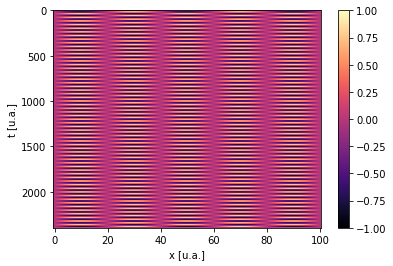

In [15]:
# Creacion de matriz espacio-temporal
matriz_x_contra_t = np.array([b for a,b in user_data['u']])

# Visualización de la matriz espacio-temporal
plt.imshow(matriz_x_contra_t, aspect='auto', cmap='magma')
plt.xlabel('x [u.a.]')
plt.ylabel('t [u.a.]')
plt.colorbar()

In [16]:
# Se agrega una función que permite manipular los pasos temporales para ver el fenómeno en dicha dimensión
@interact 
def space_cut(n=(0, matriz_x_contra_t.shape[1] - 1)):
    "Plots time profile at fixed position."
    plt.plot(matriz_x_contra_t[:, n])
    plt.xlim(0,len(user_data['u']))
    plt.ylim(-1.1,1.1)
    plt.xlabel('t [u.a]')
    plt.ylabel('Amplitud [u.a]')
    plt.grid()

interactive(children=(IntSlider(value=50, description='n'), Output()), _dom_classes=('widget-interact',))

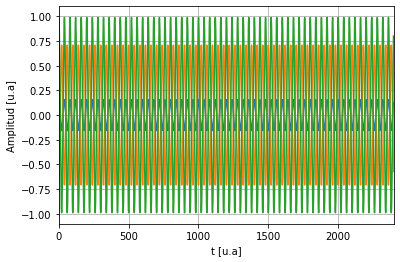

In [17]:
# Se pueden observar instantes de tiempo específicos
space_cut(1)
space_cut(25)
space_cut(49)

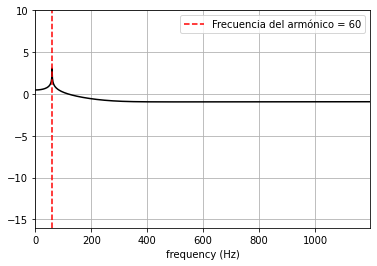

In [18]:
# FRECUENCIA DE OSCILACION
@interact 
def space_cut_frequency(n=(0, matriz_x_contra_t.shape[1] - 1)):
    "Plots time profile at fixed position."
    sig     = matriz_x_contra_t[:, n]
    X       = np.fft.rfft(sig)
    X_log   = np.log10(np.abs(X))
    idx_max = X_log.argmax()
    freqs   = np.fft.rfftfreq(sig.size, d=user_data['u'][1][0] - user_data['u'][0][0])
    plt.plot(freqs, np.log10(np.abs(X)),'k')
    # plt.plot(freqs[idx_max],X_log[idx_max],'o')
    plt.axvline(x=freqs[idx_max],ymax = X_log[idx_max],color='r',linestyle = '--', label = 'Frecuencia del armónico = ' + str(idx_max))
    plt.xlabel('frequency (Hz)')
    plt.xlim(min(freqs),max(freqs))
    plt.ylim(-16,10)
    plt.grid()
    plt.legend()

## **3. Procedimiento**

### **3.1 Longitud constante y tensión variable**

1.   Para desarrollar esta práctica se usarán los códigos de las secciones 2.2 y 2.3 Primero, busque la celda $\texttt{PARAMETROS A MANIPULAR}$ y fije $\texttt{n_pesas}$ en 9, $\texttt{L}$ en 1, y $\texttt{n}$ en 1.

2.   Ejecute todas las celdas de código de la sección 2.2. Cuando estas terminen, se generará un vídeo que presenta una animación del fenómeno de la cuerda fija en dos extremos, sometida a una exitación sinusoidal.

3.   Ejecute todas las celdas de código de la sección 2.3. Cuando terminan de ejecutar, se obtienen gráficas interactivas que presentan el mismo fenómeno de la cuerda tensa, pero en esta ocasión en la dimensión temporal.


4.   Vaya a la celda $\texttt{FRECUENCIA DE OSCILACION}$ de la sección 2.3, y usando el control deslizante, determine la frecuencia de oscilacion del fenómeno. Esta frecuencia corresponde a la del armónico fundamental.

5.   Consigne los resultados que obtuvo en los procedimientos previos en la tabla.



6.   Repita los pasos anteriores para distintos números de masas (8,7,6 y 5), variando la cantidad de armónicos de acuerdo a lo que sugiere la tabla.

\begin{array}{lccccc}
\hline
\textbf{Tension } \mathbf{[N]}& 2.6065942799999995 N  & 2.37123588 N & 2.13587748 N & 1.9005190800000002 N& 1.66516068 N \\
\textbf{Armonicos }&\mathbf{f_{n} }\mathbf{[Hz]}&\mathbf{f_{n} }\mathbf{[Hz]}&\mathbf{f_{n} }\mathbf{[Hz]}&\mathbf{f_{n} }\mathbf{[Hz]}&\mathbf{f_{n} }\mathbf{[Hz]} \\
\hline
 1 & 13 & 13 & 12 & 11 & 11 \\
 2 & 26 & 25 & 24 & 23 & 21 \\
 3 & 40 & 38 & 36 & 34 & 32 \\
 4 & 53 & 50 & 48 & 45 & 42 \\
 5 & 66 & 63 & 60 & 56 & 53 \\
\hline
\end{array}

### **3.2 Tensión constante y longitud variable**

1.   Ahora, en la celda $\texttt{PARAMETROS A MANIPULAR}$ fije $\texttt{n_pesas}$ en 9, $\texttt{L}$ en 1, y $\texttt{k}$ en 1$*\texttt{np.pi}$.

2.   Ejecute todas las celdas de código de la sección 2.2. Cuando estas terminen, se generará un vídeo que presenta una animación del fenómeno de la cuerda fija en dos extremos, sometida a una exitación sinusoidal.

3.   Ejecute todas las celdas de código de la sección 2.3. Cuando terminan de ejecutar, vaya a la celda $\texttt{FRECUENCIA DE OSCILACION}$ de la sección 2.3, y usando el control deslizante, determine la frecuencia de oscilacion del fenómeno.


4.   Consigne los resultados que obtuvo en los procedimientos previos en la tabla.



5.   Repita los pasos anteriores para distintos valores de longitud. SUGERENCIA: varíe en pasos de $0.1~m$ por encima de la longitud inicial.

\begin{array}{lccccc}
\hline
\textbf{Longitud } \mathbf{[m]}& 1.1 & 1.2 & 1.3 & 1.4 & 1.5 \\
\textbf{Armonicos }&\mathbf{f_{n} }\mathbf{[Hz]}&\mathbf{f_{n} }\mathbf{[Hz]}&\mathbf{f_{n} }\mathbf{[Hz]}&\mathbf{f_{n} }\mathbf{[Hz]}&\mathbf{f_{n} }\mathbf{[Hz]} \\
\hline
 1 & 12 & 11 & 10 & 9 & 9 \\
 2 & 24 & 22 & 20 & 19 & 18 \\
 3 & 36 & 33 & 30 & 28 & 26 \\
 4 & 48 & 44 & 41 & 38 & 35 \\
 5 & 60 & 55 & 51 & 47 & 44 \\
\hline
\end{array}

## **4. Análisis**

### **4.1 Longitud constante y tensión variable**

1.   Construya una gráfica de frecuencia en función del número de armónicos $n$ para los resultados de la sección 3.1. ¿Qué clase de curva obtiene? ¿Cómo varía la frecuencia en función de los armónicos?



RESPUESTA: Para graficar los resultados se usa la misma figura. Las gráficas que se obtienen son rectas, lo que indice que hay una relación lineal entre el número de armónicos de la oscilación y su frecuencia, cuando la longitud es constante y la tensión es variable.

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
# Se crean los vectores de armónicos contra frecuencia
armonicos  = np.array([1,2,3,4,5]).reshape(-1, 1)
frecuencia = np.zeros((5,5))
frecuencia[0,:] = [13,26,40,53,66]
frecuencia[1,:] = [13,25,38,50,63]
frecuencia[2,:] = [12,24,36,48,60]
frecuencia[3,:] = [11,23,34,45,56]
frecuencia[4,:] = [11,21,32,42,53]

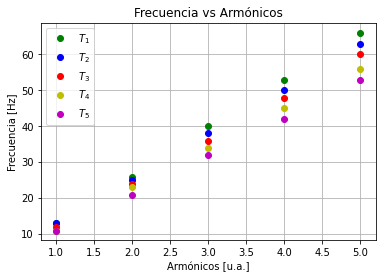

In [21]:
# Se grafican los armónicos contra la frecuencia
plt.figure()
# Descomentar estas líneas una vez creen los vectores para armónicos y frecuencia. Para descomentar Ctrl + /
plt.plot(armonicos,frecuencia[0,:],'go',label = r'$T_{1}$')
plt.plot(armonicos,frecuencia[1,:],'bo',label = r'$T_{2}$')
plt.plot(armonicos,frecuencia[2,:],'ro',label = r'$T_{3}$')
plt.plot(armonicos,frecuencia[3,:],'yo',label = r'$T_{4}$')
plt.plot(armonicos,frecuencia[4,:],'mo',label = r'$T_{5}$')
plt.title(r'Frecuencia vs Armónicos')
plt.xlabel(r'Armónicos [u.a.]')
plt.ylabel(r'Frecuencia [Hz]')
plt.grid()
plt.legend()
plt.show()

In [22]:
# Se le aplica regresión a los datos
reg_lineal_T1 = LinearRegression()
reg_lineal_T2 = LinearRegression()
reg_lineal_T3 = LinearRegression()
reg_lineal_T4 = LinearRegression()
reg_lineal_T5 = LinearRegression()

# Una vez se tengan los vectores de radiación térmica y temperatura, descomentar esta línea (Ctrl + /)
reg_lineal_T1.fit(armonicos,frecuencia[0,:])
reg_lineal_T2.fit(armonicos,frecuencia[1,:])
reg_lineal_T3.fit(armonicos,frecuencia[2,:])
reg_lineal_T4.fit(armonicos,frecuencia[3,:])
reg_lineal_T5.fit(armonicos,frecuencia[4,:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

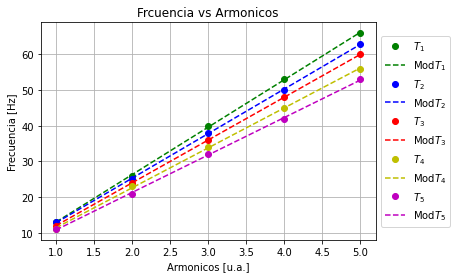

In [23]:
# Se obtiene la recta a partir de la regresión aplicada
modelo_T1 = reg_lineal_T1.predict(armonicos)
modelo_T2 = reg_lineal_T2.predict(armonicos)
modelo_T3 = reg_lineal_T3.predict(armonicos)
modelo_T4 = reg_lineal_T4.predict(armonicos)
modelo_T5 = reg_lineal_T5.predict(armonicos)

# Se grafica la distancia contra la frecuencia y sus respectivos modelos ajustados
plt.figure()
# Descomentar estas líneas una vez creen los vectores para distancia y frecuencia. Para descomentar Ctrl + /
plt.plot(armonicos,frecuencia[0,:],'go',label = r'$T_{1}$')
plt.plot(armonicos,modelo_T1,'g--',label = 'Mod' + r'$T_{1}$')
plt.plot(armonicos,frecuencia[1,:],'bo',label = r'$T_{2}$')
plt.plot(armonicos,modelo_T2,'b--',label = 'Mod' + r'$T_{2}$')
plt.plot(armonicos,frecuencia[2,:],'ro',label = r'$T_{3}$')
plt.plot(armonicos,modelo_T3,'r--',label = 'Mod' + r'$T_{3}$')
plt.plot(armonicos,frecuencia[3,:],'yo',label = r'$T_{4}$')
plt.plot(armonicos,modelo_T4,'y--',label = 'Mod' + r'$T_{4}$')
plt.plot(armonicos,frecuencia[4,:],'mo',label = r'$T_{5}$')
plt.plot(armonicos,modelo_T5,'m--',label = 'Mod' + r'$T_{5}$')
plt.title(r'Frcuencia vs Armonicos')
plt.xlabel(r'Armonicos [u.a.]')
plt.ylabel(r'Frecuencia [Hz]')
plt.grid()
plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [24]:
# Se imprime el valor del intercepto para cada una de las rectas
print("b = " + str(reg_lineal_T5.intercept_))
# Se imprime el valor de la pendiente cada una de las rectas
print("m = " + str(reg_lineal_T5.coef_))

b = 0.3000000000000007
m = [10.5]


2.   Si las gráficas obtenidas en el punto anterior son rectas, haga el análisis correspondiente para obtener el valor de la densidad de masa $\mu_e$ (valor experimental de la simulación) para cada valor de tensión y rellene la tabla. Parta de la expresión para la frecuencia $f$ presentada en la guía.

RESPUESTA: 

*   $f_n=\frac{n}{2L}\sqrt\frac{T}{\mu}$ 
*   $\mu=\frac{T*n^2}{f_n^2*4L^2}$

Donde:

*   Siendo $f_n=m_n*n+b_n$





3.   Calcule el error porcentual para el valor de $\mu_e$, teniendo en cuenta que el valor real de $\mu$ es  $0.00375384030418251~kg/m$

RESPUESTA: Para resolver esta parte, se calcula el error para cada una de las mediciones asociadas a cada tensión usada.

In [0]:
# Se crea el vector de tensiones
tensiones         = np.array([2.6065942799999995,2.37123588,2.13587748,1.9005190800000002,1.66516068]).reshape(1,-1)
vector_pendientes = np.array([reg_lineal_T1.coef_,reg_lineal_T2.coef_,reg_lineal_T3.coef_,reg_lineal_T4.coef_,reg_lineal_T5.coef_]).reshape(1,-1)
vector_interceptos= np.array([reg_lineal_T1.intercept_,reg_lineal_T2.intercept_,reg_lineal_T3.intercept_,reg_lineal_T4.intercept_,reg_lineal_T5.intercept_]).reshape(1,-1)
longitud          = 1.0
n_armonico        = 5

In [26]:
# Calculo del valor experimental de la densidad de masa lineal de la cuerda
mu_e= (tensiones*n_armonico**2)/((4*longitud**2)*(vector_pendientes*n_armonico+vector_interceptos)**2)

print('Vector de mu_e = ' + str(mu_e))

Vector de mu_e = [[0.00371738 0.00375782 0.00370812 0.00376079 0.00373309]]


In [27]:
# Calculo del error porcentual entre el valor obtenido por la simulación y el valor real
mu   = 0.00375384030418251
error= (np.absolute(mu_e-mu)/mu)*100
print('Vector de errores = ' + str(np.round(error,2)))

Vector de errores = [[0.97 0.11 1.22 0.19 0.55]]


\begin{array}{lcccccccccc}
\hline
\textbf{Tension } \mathbf{[N]} & 2.6065942799999995 & & 2.37123588 & & 2.13587748 & & 1.9005190800000002 & & 1.66516068\\
\textbf{Armonicos }&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}\\
\hline
 1 &0.00385591 & 2.72 & 0.00361822 & 3.61 & 0.00370812 & 1.22 & 0.00365597 & 2.61& 0.00356902 &4.92\\
 2 & 0.00376844 & 0.39 & 0.00370454 & 1.31 & 0.00370812 & 1.22 & 0.00372096 & 0.88 & 0.00367026 & 2.23\\
 3 & 0.00373995 & 0.37 & 0.00373399 & 0.53 & 0.00370812 & 1.22 & 0.00374301 & 0.29 & 0.00370497 & 1.3\\
 4 & 0.00372582 & 0.75 & 0.00374886 & 0.13 & 0.00370812 & 1.22 & 0.00375411 & 0.01& 0.00372251 & 0.83 \\
 5 & 0.00371738 & 0.97 & 0.00375782 & 0.11 & 0.00370812 & 1.22 & 0.00376079 & 0.19 & 0.00373309 & 0.55 \\
\hline
\end{array}

4.  Contruya una gráfica de frecuencia en función de la raíz cuadrada de la tensión. ¿Es su gráfica una línea recta?

RESPUESTA: Para esta parte, se reutiliza el código de los puntos anteriores, para hacer las gráficas correspondientes.

In [0]:
# Se crean los vectores de armónicos contra frecuencia
tensiones_raiz_c   = (tensiones**(1/2)).reshape(-1,1)
frecuencia         = np.zeros((5,5))
frecuencia[0,:]    = [13,26,40,53,66]
frecuencia[1,:]    = [13,25,38,50,63]
frecuencia[2,:]    = [12,24,36,48,60]
frecuencia[3,:]    = [11,23,34,45,56]
frecuencia[4,:]    = [11,21,32,42,53]

In [29]:
# Se le aplica regresión a los datos
reg_lineal_T1 = LinearRegression()
reg_lineal_T2 = LinearRegression()
reg_lineal_T3 = LinearRegression()
reg_lineal_T4 = LinearRegression()
reg_lineal_T5 = LinearRegression()

# Una vez se tengan los vectores de radiación térmica y temperatura, descomentar esta línea (Ctrl + /)
reg_lineal_T1.fit(tensiones_raiz_c,frecuencia[0,:])
reg_lineal_T2.fit(tensiones_raiz_c,frecuencia[1,:])
reg_lineal_T3.fit(tensiones_raiz_c,frecuencia[2,:])
reg_lineal_T4.fit(tensiones_raiz_c,frecuencia[3,:])
reg_lineal_T5.fit(tensiones_raiz_c,frecuencia[4,:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

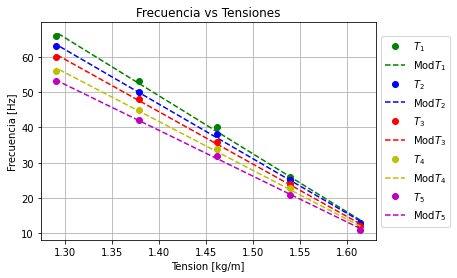

In [30]:
# Se obtiene la recta a partir de la regresión aplicada
modelo_T1 = reg_lineal_T1.predict(tensiones_raiz_c)
modelo_T2 = reg_lineal_T2.predict(tensiones_raiz_c)
modelo_T3 = reg_lineal_T3.predict(tensiones_raiz_c)
modelo_T4 = reg_lineal_T4.predict(tensiones_raiz_c)
modelo_T5 = reg_lineal_T5.predict(tensiones_raiz_c)

# Se grafica la distancia contra la frecuencia y sus respectivos modelos ajustados
plt.figure()
# Descomentar estas líneas una vez creen los vectores para distancia y frecuencia. Para descomentar Ctrl + /
plt.plot(tensiones_raiz_c,frecuencia[0,:],'go',label = r'$T_{1}$')
plt.plot(tensiones_raiz_c,modelo_T1,'g--',label = 'Mod' + r'$T_{1}$')
plt.plot(tensiones_raiz_c,frecuencia[1,:],'bo',label = r'$T_{2}$')
plt.plot(tensiones_raiz_c,modelo_T2,'b--',label = 'Mod' + r'$T_{2}$')
plt.plot(tensiones_raiz_c,frecuencia[2,:],'ro',label = r'$T_{3}$')
plt.plot(tensiones_raiz_c,modelo_T3,'r--',label = 'Mod' + r'$T_{3}$')
plt.plot(tensiones_raiz_c,frecuencia[3,:],'yo',label = r'$T_{4}$')
plt.plot(tensiones_raiz_c,modelo_T4,'y--',label = 'Mod' + r'$T_{4}$')
plt.plot(tensiones_raiz_c,frecuencia[4,:],'mo',label = r'$T_{5}$')
plt.plot(tensiones_raiz_c,modelo_T5,'m--',label = 'Mod' + r'$T_{5}$')
plt.title(r'Frecuencia vs Tensiones')
plt.xlabel(r'Tension [kg/m]')
plt.ylabel(r'Frecuencia [Hz]')
plt.grid()
plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [31]:
# Se imprime el valor del intercepto para cada una de las rectas
print("b = " + str(reg_lineal_T5.intercept_))
# Se imprime el valor de la pendiente cada una de las rectas
print("m = " + str(reg_lineal_T5.coef_))

b = 220.6374767033061
m = [-129.60980764]


5.   A partir del gráfico, obtenga la ecuación que relaciona la frecuencia con la tensión y de esta ecuación obtenga un nuevo valor para $\mu$.

RESPUESTA: 


*   $\mu=\frac{n^2*T}{4L^2*f_n}$
*   Siendo $f_n=m_n\sqrt T+ b_n$



6.   Calcule el error porcentual para el valor de $\mu_e$, utilizando la aproximación previa, teniendo en cuenta que el valor real de $\mu$ es  $0.00375384030418251~kg/m$

RESPUESTA: Para resolver esta parte, se calcula el error para cada una de las mediciones asociadas a cada tensión usada.

In [0]:
# Se crea el vector de tensiones
tensiones         = np.array([2.6065942799999995,2.37123588,2.13587748,1.9005190800000002,1.66516068]).reshape(1,-1)
vector_pendientes = np.array([reg_lineal_T1.coef_,reg_lineal_T2.coef_,reg_lineal_T3.coef_,reg_lineal_T4.coef_,reg_lineal_T5.coef_]).reshape(1,-1)
vector_interceptos= np.array([reg_lineal_T1.intercept_,reg_lineal_T2.intercept_,reg_lineal_T3.intercept_,reg_lineal_T4.intercept_,reg_lineal_T5.intercept_]).reshape(1,-1)
longitud          = 1.0
n_armonico        = 5

In [33]:
# Calculo del valor experimental de la densidad de masa lineal de la cuerda
mu_e = (tensiones*n_armonico**2)/((4*longitud**2)*((vector_pendientes*(tensiones)**(1/2))+vector_interceptos)**2)
print('Vector de mu_e = ' + str(mu_e))

Vector de mu_e = [[0.08615297 0.02369847 0.01069209 0.00596416 0.00365137]]


In [34]:
# Calculo del error porcentual entre el valor obtenido por la simulación y el valor real
mu   = 0.00375384030418251
error= (np.absolute(mu_e-mu)/mu)*100
print('Vector de errores = ' + str(np.round(error,2)))

Vector de errores = [[2195.06  531.31  184.83   58.88    2.73]]


\begin{array}{lcccccccccc}
\hline
\textbf{Tension } \mathbf{[N]} & 2.6065942799999995 & & 2.37123588  & & 2.13587748  & & 1.9005190800000002 & & 1.66516068 \\
\textbf{Armonicos }&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}\\
\hline
1 &  0.00344612 & 8.2 & 0.00094794 & 74.75 & 0.00042768 & 88.61 & 0.00023857 & 93.64 & 0.00014605 & 96.11 \\
2 & 0.01378447 & 267.21 & 0.00379175 & 1.01 & 0.00171073 & 54.43 & 0.00095427  & 74.58 & 0.00058422 & 84.44 \\
3 & 0.03101507 & 726.22 & 0.00853145 & 127.27 & 0.00384915 & 2.54 & 0.0021471 & 42.8 & 0.00131449 & 64.98 \\
4 &  0.0551379 & 1368.84 & 0.01516702 & 304.04 & 0.00684294 & 82.29 & 0.00381706 & 1.68 & 0.00233688 & 37.75\\
5 &  0.08615297 & 2195.06 & 0.02369847 & 531.31 & 0.01069209 & 184.83 & 0.00596416 & 58.88 & 0.00365137 & 2.73 \\
\hline
\end{array}

### **4.2 Tensión constante y longitud variable**

1.   Construya una gráfica de frecuencia en función del número de armónicos $n$ para los resultados de la sección 3.2. ¿Qué clase de curva obtiene? ¿Cómo varía la frecuencia en función de los armónicos?

RESPUESTA: 

In [0]:
# Se crean los vectores de armónicos contra frecuencia
armonicos  = np.array([1,2,3,4,5]).reshape(-1, 1)
frecuencia = np.zeros((5,5))
frecuencia[0,:] = [12,24,36,48,60]
frecuencia[1,:] = [11,22,33,44,55]
frecuencia[2,:] = [10,20,30,41,51]
frecuencia[3,:] = [9,19,28,38,47]
frecuencia[4,:] = [9,18,26,35,44]

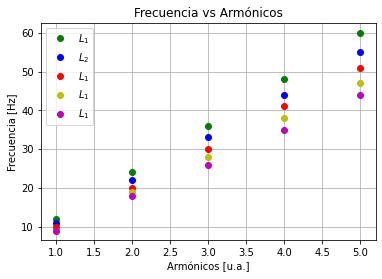

In [37]:
# Se grafican los armónicos contra la frecuencia
plt.figure()
# Descomentar estas líneas una vez creen los vectores para armónicos y frecuencia. Para descomentar Ctrl + /
plt.plot(armonicos,frecuencia[0,:],'go',label = r'$L_{1}$')
plt.plot(armonicos,frecuencia[1,:],'bo',label = r'$L_{2}$')
plt.plot(armonicos,frecuencia[2,:],'ro',label = r'$L_{1}$')
plt.plot(armonicos,frecuencia[3,:],'yo',label = r'$L_{1}$')
plt.plot(armonicos,frecuencia[4,:],'mo',label = r'$L_{1}$')
plt.title(r'Frecuencia vs Armónicos')
plt.xlabel(r'Armónicos [u.a.]')
plt.ylabel(r'Frecuencia [Hz]')
plt.grid()
plt.legend()
plt.show()

In [38]:
# Se le aplica regresión a los datos
reg_lineal_L1 = LinearRegression()
reg_lineal_L2 = LinearRegression()
reg_lineal_L3 = LinearRegression()
reg_lineal_L4 = LinearRegression()
reg_lineal_L5 = LinearRegression()

# Una vez se tengan los vectores de radiación térmica y temperatura, descomentar esta línea (Ctrl + /)
reg_lineal_L1.fit(armonicos,frecuencia[0,:])
reg_lineal_L2.fit(armonicos,frecuencia[1,:])
reg_lineal_L3.fit(armonicos,frecuencia[2,:])
reg_lineal_L4.fit(armonicos,frecuencia[3,:])
reg_lineal_L5.fit(armonicos,frecuencia[4,:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

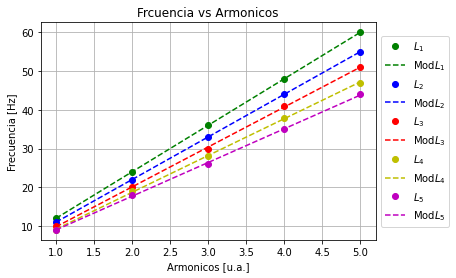

In [39]:
# Se obtiene la recta a partir de la regresión aplicada
modelo_L1 = reg_lineal_L1.predict(armonicos)
modelo_L2 = reg_lineal_L2.predict(armonicos)
modelo_L3 = reg_lineal_L3.predict(armonicos)
modelo_L4 = reg_lineal_L4.predict(armonicos)
modelo_L5 = reg_lineal_L5.predict(armonicos)

# Se grafica la distancia contra la frecuencia y sus respectivos modelos ajustados
plt.figure()
# Descomentar estas líneas una vez creen los vectores para distancia y frecuencia. Para descomentar Ctrl + /
plt.plot(armonicos,frecuencia[0,:],'go',label = r'$L_{1}$')
plt.plot(armonicos,modelo_L1,'g--',label = 'Mod' + r'$L_{1}$')
plt.plot(armonicos,frecuencia[1,:],'bo',label = r'$L_{2}$')
plt.plot(armonicos,modelo_L2,'b--',label = 'Mod' + r'$L_{2}$')
plt.plot(armonicos,frecuencia[2,:],'ro',label = r'$L_{3}$')
plt.plot(armonicos,modelo_L3,'r--',label = 'Mod' + r'$L_{3}$')
plt.plot(armonicos,frecuencia[3,:],'yo',label = r'$L_{4}$')
plt.plot(armonicos,modelo_L4,'y--',label = 'Mod' + r'$L_{4}$')
plt.plot(armonicos,frecuencia[4,:],'mo',label = r'$L_{5}$')
plt.plot(armonicos,modelo_L5,'m--',label = 'Mod' + r'$L_{5}$')
plt.title(r'Frcuencia vs Armonicos')
plt.xlabel(r'Armonicos [u.a.]')
plt.ylabel(r'Frecuencia [Hz]')
plt.grid()
plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [40]:
# Se imprime el valor del intercepto para una de las rectas elegidas
print("b = " + str(reg_lineal_L1.intercept_))
# Se imprime el valor de la pendiente una de las rectas elegidas
print("m = " + str(reg_lineal_L1.coef_))

b = -1.4210854715202004e-14
m = [12.]


2.   Usando la expresión obtenida en el punto 2 de la sección 4.1, calcule el valor de $\mu_e$, pero teniendo en cuenta que ahora lo que es constante es la tensión y lo variable la longitud.

RESPUESTA: 

3.   Calcule el error porcentual para el valor de $\mu_e$, teniendo en cuenta que el valor real de $\mu$ es  $0.00375384030418251~kg/m$

RESPUESTA: Para resolver esta parte, se calcula el error para cada una de las mediciones asociadas a cada longitud usada.

In [0]:
# Se crea el vector de tensiones
tensiones         = 2.6065942799999995 
vector_pendientes = np.array([reg_lineal_L1.coef_,reg_lineal_L2.coef_,reg_lineal_L3.coef_,reg_lineal_L4.coef_,reg_lineal_L5.coef_]).reshape(1,-1)
vector_interceptos= np.array([reg_lineal_L1.intercept_,reg_lineal_L2.intercept_,reg_lineal_L3.intercept_,reg_lineal_L4.intercept_,reg_lineal_L5.intercept_]).reshape(1,-1)
longitud          = np.array([1.1,1.2,1.3,1.4,1.5]).reshape(1,-1)
n_armonico        = 5

In [42]:
# Calculo del valor experimental de la densidad de masa lineal de la cuerda
mu_e = (n_armonico**2*tensiones)/((4*longitud**2)*(vector_pendientes*n_armonico+vector_interceptos)**2)
print('Vector de mu_e = ' + str(mu_e))

Vector de mu_e = [[0.00373995 0.00373995 0.00370618 0.0037309  0.00377418]]


In [43]:
# Calculo del error porcentual entre el valor obtenido por la simulación y el valor real
mu   = 0.00375384030418251
error= (np.absolute(mu_e-mu)/mu)*100
print('Vector de errores = ' + str(np.round(error,2)))

Vector de errores = [[0.37 0.37 1.27 0.61 0.54]]


\begin{array}{lcccccccccc}
\hline
\textbf{Longitud } \mathbf{[m]} & 1.1 & & 1.2 & & 1.3 & & 1.4 & & 1.5\\
\textbf{Armonicos }&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}\\
\hline
1 & 0.00373995 & 0.37 & 0.00373995 & 0.37 & 0.0040149 & 6.95 & 0.00392809 & 4.64 & 0.00357558 & 4.75 \\ 
2 & 0.00373995 & 0.37 & 0.00373995 & 0.37 & 0.00381764 & 1.7 & 0.00380307 & 1.31 & 0.00369781 & 1.49 \\ 
3 &  0.00373995 & 0.37 & 0.00373995 & 0.37 & 0.0037551 & 0.03 & 0.00376272 & 0.24 & 0.00373995 & 0.37\\ 
4 & 0.00373995 & 0.37 & 0.00373995 & 037 & 0.00372441 & 0.78 & 0.00374278 & 0.29 & 0.00376129 & 0.2\\ 
5 & 0.00373995 & 0.37 & 0.00373995 & 0.37 & 0.00370618 & 1.27 & 0.0037309 & 0.61 &  0.00377418 & 0.54\\ 
\hline
\end{array}

4.  Contruya una gráfica de frecuencia en función del inverso de la longitud de la cuerda. ¿Es su gráfica una línea recta?

RESPUESTA: Para esta parte, se reutiliza el código de los puntos anteriores, para hacer las gráficas correspondientes.

In [0]:
# Se crean los vectores de armónicos contra frecuencia
longitudes_inv     = (1/longitud).reshape(-1,1)
frecuencia         = np.zeros((5,5))
frecuencia[0,:]    = [12,24,36,48,60]
frecuencia[1,:]    = [11,22,33,44,55]
frecuencia[2,:]    = [10,20,30,41,51]
frecuencia[3,:]    = [9,19,28,38,47]
frecuencia[4,:]    = [9,18,26,35,44]

In [45]:
# Se le aplica regresión a los datos
reg_lineal_L1 = LinearRegression()
reg_lineal_L2 = LinearRegression()
reg_lineal_L3 = LinearRegression()
reg_lineal_L4 = LinearRegression()
reg_lineal_L5 = LinearRegression()

# Una vez se tengan los vectores de radiación térmica y temperatura, descomentar esta línea (Ctrl + /)
reg_lineal_L1.fit(longitudes_inv,frecuencia[0,:])
reg_lineal_L2.fit(longitudes_inv,frecuencia[1,:])
reg_lineal_L3.fit(longitudes_inv,frecuencia[2,:])
reg_lineal_L4.fit(longitudes_inv,frecuencia[3,:])
reg_lineal_L5.fit(longitudes_inv,frecuencia[4,:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

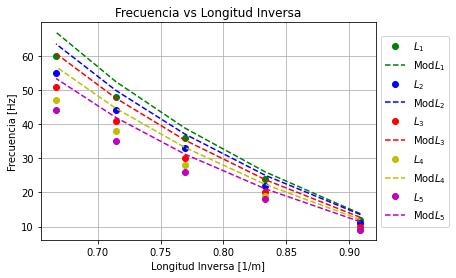

In [46]:
# Se obtiene la recta a partir de la regresión aplicada
modelo_L1 = reg_lineal_L1.predict(longitudes_inv)
modelo_L2 = reg_lineal_L2.predict(longitudes_inv)
modelo_L3 = reg_lineal_L3.predict(longitudes_inv)
modelo_L4 = reg_lineal_L4.predict(longitudes_inv)
modelo_L5 = reg_lineal_L5.predict(longitudes_inv)

# Se grafica la distancia contra la frecuencia y sus respectivos modelos ajustados
plt.figure()
# Descomentar estas líneas una vez creen los vectores para distancia y frecuencia. Para descomentar Ctrl + /
plt.plot(longitudes_inv,frecuencia[0,:],'go',label = r'$L_{1}$')
plt.plot(longitudes_inv,modelo_T1,'g--',label = 'Mod' + r'$L_{1}$')
plt.plot(longitudes_inv,frecuencia[1,:],'bo',label = r'$L_{2}$')
plt.plot(longitudes_inv,modelo_T2,'b--',label = 'Mod' + r'$L_{2}$')
plt.plot(longitudes_inv,frecuencia[2,:],'ro',label = r'$L_{3}$')
plt.plot(longitudes_inv,modelo_T3,'r--',label = 'Mod' + r'$L_{3}$')
plt.plot(longitudes_inv,frecuencia[3,:],'yo',label = r'$L_{4}$')
plt.plot(longitudes_inv,modelo_T4,'y--',label = 'Mod' + r'$L_{4}$')
plt.plot(longitudes_inv,frecuencia[4,:],'mo',label = r'$L_{5}$')
plt.plot(longitudes_inv,modelo_T5,'m--',label = 'Mod' + r'$L_{5}$')
plt.title(r'Frecuencia vs Longitud Inversa')
plt.xlabel(r'Longitud Inversa [1/m]')
plt.ylabel(r'Frecuencia [Hz]')
plt.grid()
plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [47]:
#Se imprime el valor del intercepto para cada una de las rectas
print("b = " + str(reg_lineal_L4.intercept_))
# Se imprime el valor de la pendiente cada una de las rectas
print("m = " + str(reg_lineal_L4.coef_))

b = 149.74565962276256
m = [-156.12370754]


5.   A partir del gráfico, obtenga la ecuación que relaciona la frecuencia con la longitud y de esta ecuación obtenga un nuevo valor para $\mu$.

RESPUESTA: 

6.   Calcule el error porcentual para el valor de $\mu_e$, utilizando la aproximación previa, teniendo en cuenta que el valor real de $\mu$ es  $0.00375384030418251~kg/m$

RESPUESTA: Para resolver esta parte, se calcula el error para cada una de las mediciones asociadas a cada longitud usada.

In [0]:
# Se crea el vector de tensiones
tensiones         = 2.60659428
vector_pendientes = np.array([reg_lineal_L1.coef_,reg_lineal_L2.coef_,reg_lineal_L3.coef_,reg_lineal_L4.coef_,reg_lineal_L5.coef_]).reshape(1,-1)
vector_interceptos= np.array([reg_lineal_L1.intercept_,reg_lineal_L2.intercept_,reg_lineal_L3.intercept_,reg_lineal_L4.intercept_,reg_lineal_L5.intercept_]).reshape(1,-1)
longitud          = np.array([1.1,1.2,1.3,1.4,1.5]).reshape(1,-1)
n_armonico        = 5

In [49]:
# Calculo del valor experimental de la densidad de masa lineal de la cuerda
mu_e = (n_armonico**2*tensiones)/((4*longitud**2)*((vector_pendientes*(longitud)**-1)+vector_interceptos)**2)
print('Vector de mu_e = ' + str(mu_e))

Vector de mu_e = [[0.12761016 0.02120239 0.00943147 0.00568745 0.00403387]]


In [50]:
# Calculo del error porcentual entre el valor obtenido por la simulación y el valor real
mu   = 0.00375384030418251
error= (np.absolute(mu_e-mu)/mu)*100
print('Vector de errores = ' + str(np.round(error,2)))

Vector de errores = [[3299.46  464.82  151.25   51.51    7.46]]


\begin{array}{lcccccccccc}
\hline
\textbf{Longitud } \mathbf{[m]} & 1.1 & & 1.2 & & 1.3 & & 1.4 & & 1.5\\
\textbf{Armonicos }&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}&\mathbf{\mu_{e} }\mathbf{[kg/m]}&\textbf{E}\mathbf{[\%]}\\
\hline
1 & 0.00510441 & 35.98 & 0.0008481 & 77.41 & 0.00037726 & 89.95 & 0.0002275 & 93.94 &  0.00016135 & 95.7   \\
2 & 0.02041763 & 443.91 & 0.00339238 & 9.63 & 0.00150904 & 59.8 & 0.00090999 & 75.76 & 0.00064542 & 82.81  \\
3 & 0.04593966 & 1123.8 & 0.00763286 & 103.33 & 0.00339533 & 9.55 & 0.00204748 & 45.46 & 0.00145219 & 61.31  \\
4 & 0.0816705 & 2075.65 & 0.01356953 & 261.48 & 0.00603614 & 60.8 & 0.00363997 & 3.03 & 0.00258168 & 31.23 \\
5 & 0.12761016 & 3299.46 & 0.02120239 & 464.82 &  0.00943147 & 151.25 & 0.00568745 & 51.51 & 0.00403387 & 7.46 \\
\hline
\end{array}

7. ¿Cuál de todas las formas como se calculó el valor de $\mu$ a partir de los resultados de la simulación, arroja resultados más cercanos al valor real?

RESPUESTA: Hay dos formas en la que el error es minimo, la primera es la tension cte y la longitud variable con un promedio de error de 1.1548, y la segunda mas exacta es la de la longitud cte y la frecuencia varible con un promedio de error de 1.2356, por ende se puede escoger cualquiera de las dos. 

# **5. Conclusiones**


*  Se entendio cuáles son los modos propios de oscilación del sistema, la forma en que hay que combinar los elementos para alcanzar las frecuencias propias del sistema: variando la tensión o la longitud entre los extremos fijos. 
*  El comportamiento del sistema está determinado por la longitud entre los puntos fijos de la cuerda, la frecuencia de vibración y la tensión que en este caso depende de la masa.
*   El calculo de error en la densidad de masa lineal calculada y teorica, es casi cuando el sistema esta en el armonico 5.




